<a href="https://colab.research.google.com/github/moraesv/chatbot-telegram-fake-news/blob/main/TCC_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Monta repo do drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Descompacta as noticias

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/noticias.zip", 'r')
zip_ref.extractall("/content/noticias")
zip_ref.close()

Remove as noticias se necessário

In [ ]:
#import shutil
#shutil.rmtree('/content/noticias')

### Agrupa as informações de todas as notícias

In [ ]:
import os
import csv
import shutil
import pandas as pd

pathFake = "/content/noticias/fake/"
pathFakeMeta = "/content/noticias/fake-meta-information/"
pathTrue = "/content/noticias/true/"
pathTrueMeta = "/content/noticias/true-meta-information/"
pathFakeRecogna = "/content/noticias/FakeRecogna.xlsx"

# cria vetor para armazenar todas as noticias
data = []

# percorre todas as notícias falsas
# obtem o texto, número e classe da noticía e meta informações como tema e data
for nameFake in os.listdir(pathFake):
    info = { "text":"","theme": "","class": "fake" }  
    number = 0
    with open(pathFake + nameFake, "r") as fakeFile:
      number = nameFake.split(".")
      content = " ".join(line.strip() for line in fakeFile)
      number = number[0]
      info["text"] = content.replace('|','')

    if number:
      nameFakeMeta = number + "-meta" + ".txt"
      with open(pathFakeMeta + nameFakeMeta, "r") as fakeMetaFile:
        fakeMetaLines = fakeMetaFile.readlines()
        info["theme"] = fakeMetaLines[2].rstrip("\n")

        if info["theme"] == 'sociedade_cotidiano':
          info["theme"] = 'mundo'
        if info["theme"] == 'tv_celebridades':
          info["theme"] = 'entretenimento'

        data.append(info)

# percorre todas as notícias verdadeiras
# obtem o texto, número e classe da noticía e meta informações como tema e data
for nameTrue in os.listdir(pathTrue):
    info = {  "text":"","theme": "","class": "true" }  
    number = 0
    with open(pathTrue + nameTrue, "r") as trueFile:
      number = nameTrue.split(".")
      content = " ".join(line.strip() for line in trueFile)
      number = number[0]
      info["text"] = content.replace('|','')

    if number:
      nameTrueMeta = number + "-meta" + ".txt"
      with open(pathTrueMeta + nameTrueMeta, "r") as trueMetaFile:
        trueMetaLines = trueMetaFile.readlines()
        info["theme"] = trueMetaLines[2].rstrip("\n")

        if info["theme"] == 'sociedade_cotidiano':
          info["theme"] = 'mundo'
        if info["theme"] == 'tv_celebridades':
          info["theme"] = 'entretenimento'
        data.append(info)

# obtem dados do fakeRecogna
excel_data = pd.read_excel(pathFakeRecogna)
# Read the values of the file in the dataframe
dfFakeRecogna = pd.DataFrame(excel_data, columns=['Noticia', 'Categoria', 'Data', 'Classe'])
# Print the content

dfFakeRecogna = dfFakeRecogna.dropna()
dfFakeRecogna['Classe'] = dfFakeRecogna['Classe'].astype(int) 
dfFakeRecogna['Classe'] = dfFakeRecogna['Classe'].map({0:'fake', 1:'true'})

for index, row in dfFakeRecogna.iterrows():
  info = { "text":"","theme": "","class": "fake",  } 
  info["text"] = str(row['Noticia']).replace('|','').replace("\n",'') .replace("\r",'').replace("\r\n",'')  
  info["theme"] = row['Categoria']
  info["class"] = row['Classe']

  if info["theme"] == 'ciência':
    info["theme"] = 'ciencia_tecnologia'

  data.append(info)

# obtem os nomes das colunas
keys = data[0].keys()

# gera arquivo csv com todas as notícias
with open('/content/noticias/todas_noticias.csv', 'w', encoding='utf8', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys, delimiter="|", quoting=csv.QUOTE_NONE, quotechar='', escapechar='\\')
    dict_writer.writeheader()
    dict_writer.writerows(data)

# envia para um zip no drive
!zip "/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/todas_noticias.zip" "/content/noticias/todas_noticias.csv"


# copia para o drive
shutil.copy("/content/noticias/todas_noticias.csv","/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO")

updating: content/noticias/todas_noticias.csv (deflated 64%)


'/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/todas_noticias.csv'

### Realiza os imports

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 6.7 MB/s 


In [ ]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
import re
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from unidecode import unidecode
import pickle
import zipfile

nltk.download('stopwords') # caso a lista esteja desatualizada
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Função read_data

In [ ]:
# criando a função para ler o arquivo
def read_data(filename):
    
    # importando o arquivo
    data = pd.read_csv(filename, sep='|')
       
    # retornando o arquivo
    return data

### Função text_prepare

In [ ]:
# criando os objetos com as expressões regulares
remove_espec_carac = re.compile('[/(){}\[\]\|@,;]|( - )')
remove_symb = re.compile('[^0-9a-z #+\-_]')

# criando um objeto para remoção de stopwords no idioma português
listStopwords = stopwords.words('portuguese')

# criando função para normalizar os textos
def text_prepare(text):
    
    # normalizando o texto em letras minúsculas, assim facilita a preparação
    text = text.lower()
    
    # substituindo caracteres especiais por espaços em branco
    text = remove_espec_carac.sub(' ', text)
    
    # remove os acentos
    text = unidecode(text) 

    # retornando apenas letras e números
    text = remove_symb.sub('', text)
    
    # removendo as stopwords
    text = ' '.join(word for word in text.split() if word not in listStopwords)
    
    # retornando o texto modificado
    return text

In [ ]:
# criando função para testar a normalização
def test_text_prepare():
    
    # definindo os exemplos
    examples = ["Ele é hostilizado com ovada durante visita a Ribeirão Preto ** $ %"]
    
    # inserindo a resposta correta
    answers = ["hostilizado ovada durante visita ribeirao preto"]
    
    # Aplicando um loop e comparando a limpeza
    for ex, ans in zip(examples, answers):
        
    # condições para retornar se o resultado foi aprovado ou reprovado
        if text_prepare(ex) != ans:
            return "Resposta incorreta para: '%s' \nEsperando: %s \nObtido: %s" % (ex,ans,text_prepare(ex))
    return 'Testes básicos aprovados.'
# rodando a função de teste
print(test_text_prepare())

Testes básicos aprovados.


### Pré-processamento

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/todas_noticias.zip", 'r')
zip_ref.extractall("/content/noticias")
zip_ref.close()

In [ ]:
# importando os dados
df = read_data('/content/noticias/content/noticias/todas_noticias.csv')

print(f"O conjunto possui:")
print(f"{df.shape[0]} linhas")
print(f"{df.shape[1]} colunas\n")

O conjunto possui:
18750 linhas
3 colunas



In [ ]:
df.head()

,text,theme,class
0,Caiu a máscara! Número de desempregados no paí...,economia,fake
1,Nova rebelião no Rio Grande do Norte. Presos q...,mundo,fake
2,Deputado diz que é contra a liberação das drog...,politica,fake
3,Caiu a máscara do Prof. Villa da Jovem Pan. Ví...,politica,fake
4,"Lista com nomes dos parlamentares que ""assassi...",politica,fake


In [ ]:
df['text'] = df['text'].apply(text_prepare)
df['theme'] = df['theme'].apply(text_prepare)

# montar dataframe de atributos básicos
X = df[ ["text","theme"] ]

# montar dataframe de atributos alvos
Y = df[ ["class"] ]

# dividir dados em treino e test
x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.3 )

In [ ]:
df.head()

,text,theme,class
0,caiu mascara numero desempregados pais recorde...,economia,fake
1,nova rebeliao rio grande norte presos quebram ...,mundo,fake
2,deputado diz contra liberacao drogas explica r...,politica,fake
3,caiu mascara prof villa jovem pan video mostra...,politica,fake
4,lista nomes parlamentares assassinaram lava-ja...,politica,fake


In [ ]:
# salvando conjuntos preparados de noticias
!mkdir /content/noticias/preprocessadas

df.to_csv("/content/noticias/preprocessadas/preprocessadas.csv", index=False, sep="|")

# envia para um zip no drive
!zip -r "/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/preprocessadas.zip" "/content/noticias/preprocessadas"

updating: content/noticias/preprocessadas/ (stored 0%)
updating: content/noticias/preprocessadas/preprocessadas.csv (deflated 66%)


In [ ]:
# # aplicando a função nos dados de treino
# x_train['text'] = x_train['text'].apply(text_prepare)
# x_train['theme'] = x_train['theme'].apply(text_prepare)

# # aplicando a função nos dados de validação
# x_test['text'] = x_test['text'].apply(text_prepare)
# x_test['theme'] = x_test['theme'].apply(text_prepare)

In [ ]:
# salvando conjuntos preparados de treino e teste
!mkdir /content/noticias/treino_teste

x_train.to_csv("/content/noticias/treino_teste/noticias_treino.csv", index=False, sep="|")
x_test.to_csv("/content/noticias/treino_teste/noticias_teste.csv", index=False, sep="|")
y_train.to_csv("/content/noticias/treino_teste/noticias_classe_treino.csv", index=False, sep="|")
y_test.to_csv("/content/noticias/treino_teste/noticias_classe_teste.csv", index=False, sep="|")

# envia para um zip no drive
!zip -r "/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/noticias_treino_teste.zip" "/content/noticias/treino_teste"

updating: content/noticias/treino_teste/ (stored 0%)
updating: content/noticias/treino_teste/noticias_classe_teste.csv (deflated 95%)
updating: content/noticias/treino_teste/noticias_classe_treino.csv (deflated 95%)
updating: content/noticias/treino_teste/noticias_teste.csv (deflated 65%)
updating: content/noticias/treino_teste/noticias_treino.csv (deflated 65%)


### Busca conjunto pré-processado

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/noticias_treino_teste.zip", 'r')
zip_ref.extractall("/content/treino_teste")
zip_ref.close()


In [ ]:
# Buscando conjuntos de treino e teste
pathTreino = "/content/treino_teste/content/noticias/treino_teste/noticias_treino.csv"
pathTeste = "/content/treino_teste/content/noticias/treino_teste/noticias_teste.csv"
pathClasseTreino = "/content/treino_teste/content/noticias/treino_teste/noticias_classe_treino.csv"
pathClasseTeste = "/content/treino_teste/content/noticias/treino_teste/noticias_classe_teste.csv"

x_train = pd.read_csv(pathTreino, sep='|')
x_test = pd.read_csv(pathTeste, sep='|')
y_train = pd.read_csv(pathClasseTreino, sep='|')
y_test = pd.read_csv(pathClasseTeste, sep='|')

### Gráficos

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/preprocessadas.zip", 'r')
zip_ref.extractall("/content/preprocessadas")
zip_ref.close()

pathPreProcessadas = "/content/preprocessadas/content/noticias/preprocessadas/preprocessadas.csv"
preprocessadas = pd.read_csv(pathPreProcessadas, sep='|')

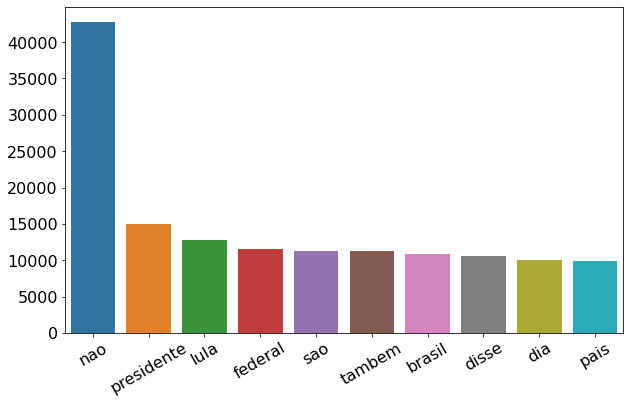

In [ ]:
# realizando a contagem e inserindo em um dicionário
all_words_counts = Counter(chain.from_iterable([i.split(" ") for i in preprocessadas['text']]))
# ordenando do maior para o menor
all_words_freq = sorted(all_words_counts.items(), key=lambda x: x[1], reverse=True)
# colocando as palavras em um objeto do tipo lista
all_words_list = list(dict(all_words_freq[:10]).keys())
# colocando as ocorrências em um objeto do tipo lista
all_occur_list = list(dict(all_words_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))
# criando o gráfico
ax = sns.barplot(x = all_words_list, y = all_occur_list)
# inserindo o título
# ax.set_title('10 palavras que mais aparecem em todo o conjunto')
# rotacionando os rótulos do eixo x
plt.xticks(rotation=30,size=16);
plt.yticks(size=16);

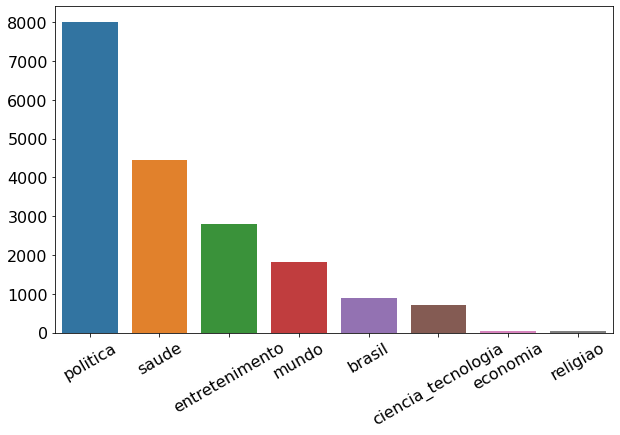

In [ ]:
# realizando a contagem e inserindo em um dicionário
all_themes_counts = Counter(chain.from_iterable([i.split(" ") for i in preprocessadas['theme']]))
# ordenando do maior para o menor
all_themes_freq = sorted(all_themes_counts.items(), key=lambda x: x[1], reverse=True)
# colocando as palavras em um objeto do tipo lista
all_themes_list = list(dict(all_themes_freq[:10]).keys())
# colocando as ocorrências em um objeto do tipo lista
all_occur_list = list(dict(all_themes_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))
# criando o gráfico
ax = sns.barplot(x = all_themes_list, y = all_occur_list)
# inserindo o título
#ax.set_title('Distribuição dos temas em todo o conjunto')
# rotacionando os rótulos do eixo x
plt.xticks(rotation=30,size=16);
plt.yticks(size=16);

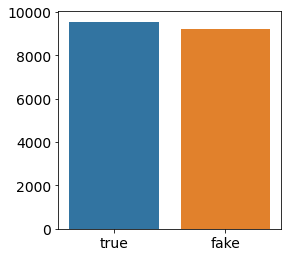

In [ ]:
# realizando a contagem e inserindo em um dicionário
all_classes_count = Counter(preprocessadas["class"])
# ordenando do maior para o menor
all_classes_freq = sorted(all_classes_count.items(), key=lambda x: x[1], reverse=True)
# colocando as palavras em um objeto do tipo lista
all_classes_list = list(dict(all_classes_freq).keys())
# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(all_classes_freq).values())

# definindo a área de plotagem
plt.figure(figsize=(4,4))
# criando o gráfico
ax = sns.barplot(x = all_classes_list, y = occur_list)
# inserindo o título
#ax.set_title('Ocorrência de notícias')
# rotacionando os rótulos do eixo x
plt.yticks(size=14);
plt.xticks(size=14);

### Dicionário

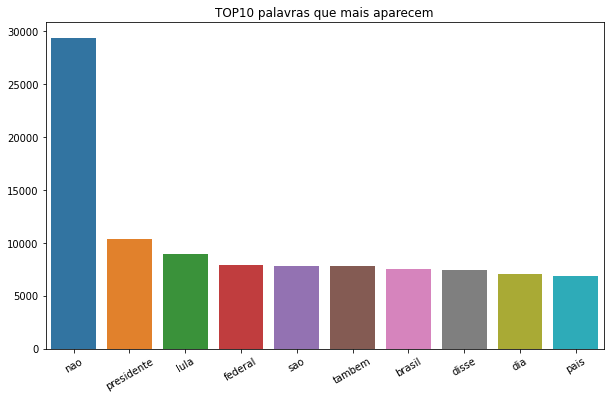

In [ ]:
# realizando a contagem e inserindo em um dicionário
words_counts = Counter(chain.from_iterable([i.split(" ") for i in x_train['text']]))
# ordenando do maior para o menor
words_freq = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)
# colocando as palavras em um objeto do tipo lista
words_list = list(dict(words_freq[:10]).keys())
# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(words_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))
# criando o gráfico
ax = sns.barplot(x = words_list, y = occur_list)
# inserindo o título
ax.set_title('TOP10 palavras que mais aparecem')
# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

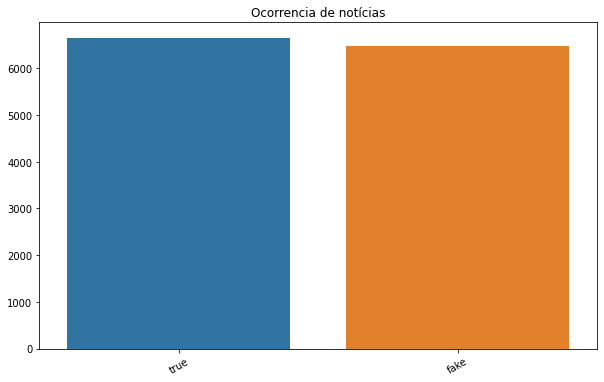

In [ ]:
# realizando a contagem e inserindo em um dicionário
classes_count = Counter(y_train["class"])
# ordenando do maior para o menor
classes_freq = sorted(classes_count.items(), key=lambda x: x[1], reverse=True)
# colocando as palavras em um objeto do tipo lista
classes_list = list(dict(classes_freq).keys())
# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(classes_freq).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))
# criando o gráfico
ax = sns.barplot(x = classes_list, y = occur_list)
# inserindo o título
ax.set_title('Ocorrencia de notícias')
# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

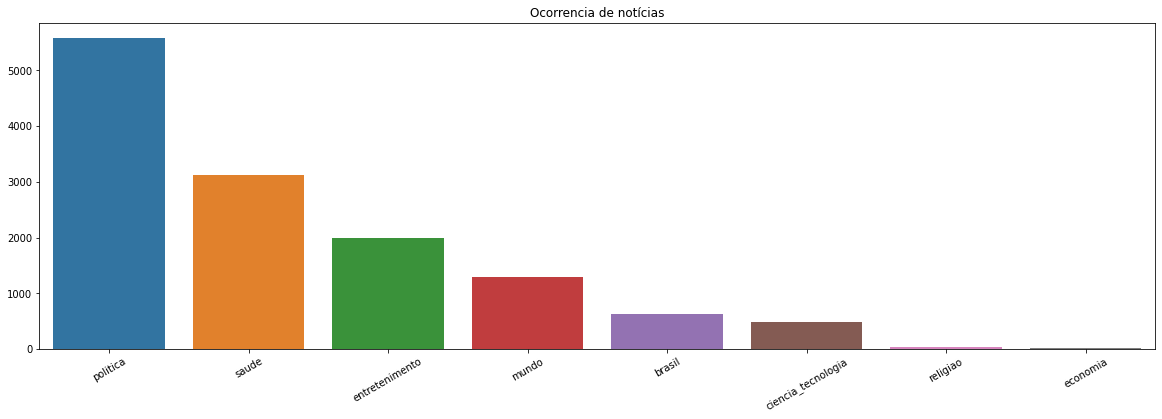

In [ ]:
# realizando a contagem e inserindo em um dicionário
theme_count = Counter(x_train["theme"])
# ordenando do maior para o menor
theme_freq = sorted(theme_count.items(), key=lambda x: x[1], reverse=True)
# colocando as palavras em um objeto do tipo lista
theme_list = list(dict(theme_freq).keys())
# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(theme_freq).values())

# definindo a área de plotagem
plt.figure(figsize=(20,6))
# criando o gráfico
ax = sns.barplot(x = theme_list, y = occur_list)
# inserindo o título
ax.set_title('Ocorrencia de notícias')
# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

### Bag of Words (BOW)

In [ ]:
# definindo um limite
max_features = 5000
# instanciando o vetorizador
vectorizer = CountVectorizer(max_features = max_features)
# aplicando a transformação
x_train_bow = vectorizer.fit_transform(x_train['text'])
x_test_bow = vectorizer.transform(x_test['text'])
# checando o shape
print('x_train shape:', x_train_bow.shape)
print('x_test shape:  ', x_test_bow.shape)

x_train shape: (13125, 5000)
x_test shape:   (5625, 5000)


In [ ]:
# com a coluna tema
enc = OneHotEncoder(handle_unknown='ignore')
max_features = 5000
vec = CountVectorizer(max_features = max_features)

transf = make_column_transformer((vec, 'text'),(enc, ['theme']))

x_train_bow = transf.fit_transform(x_train)
# aplicando o modelo com transform aos dados de validação
x_test_bow = transf.transform(x_test)

### TF-IDF - frequencias relativas


TF: term frequency ou termos frequentes

IDF: inverse document-frequency ou frequencia de documento inversa

In [ ]:
# instanciando o tfidf
tfidf_vec = TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9, ngram_range = (1,2))
# aplicando o modelo com fit_transform aos dados de treino
x_train_tfidf = tfidf_vec.fit_transform(x_train['text'])
# aplicando o modelo com transform aos dados de validação
x_test_tfidf = tfidf_vec.transform(x_test['text'])
# coletando o palavras
tfidf_vocab = tfidf_vec.vocabulary_
# invertendo o dicionário para termos a quantidade como chaves
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [ ]:
# com a coluna tema

enc = OneHotEncoder(handle_unknown='ignore')
vec =  TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9, ngram_range = (1,2))

transf = make_column_transformer((vec, 'text'),(enc, ['theme']))

x_train_tfidf = transf.fit_transform(x_train)
# aplicando o modelo com transform aos dados de validação
x_test_tfidf = transf.transform(x_test)
# coletando o palavras
tfidf_vocab = transf.transformers_[0][1].vocabulary_
# invertendo o dicionário para termos a quantidade como chaves
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [ ]:
# #sem tema
# #bow
# bow = CountVectorizer(max_features = 5000)
# x_train_bow = bow.fit_transform(x_train['text'])
# x_test_bow = bow.transform(x_test['text'])
# #tfidf
# tfidf_vec = TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9,
#                             ngram_range = (1,2))
# x_train_tfidf = tfidf_vec.fit_transform(x_train['text'])
# x_test_tfidf = tfidf_vec.transform(x_test['text'])

# # com a coluna tema
# enc = OneHotEncoder(handle_unknown='ignore')
# #bow
# bow = CountVectorizer(max_features = 5000)
# transf_bow = make_column_transformer((bow, 'text'),(enc, ['theme']))
# x_train_bow = transf_bow.fit_transform(x_train)
# x_test_bow = transf_bow.transform(x_test)
# #tfidf
# tfidf =  TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9,
#                          ngram_range = (1,2))
# transf = make_column_transformer((tfidf, 'text'),(enc, ['theme']))
# x_train_tfidf = transf.fit_transform(x_train)
# x_test_tfidf = transf.transform(x_test)

### Testando modelos

In [ ]:
# transformando as classes em 0 e 1
lb = LabelBinarizer()

y_train_bin = lb.fit_transform(y_train['class']).ravel()
y_test_bin = lb.fit_transform(y_test['class']).ravel()

#### MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(x_train_bow, y_train_bin)
print("score on test: " + str(mnb.score(x_test_bow, y_test_bin)))
print("score on train: "+ str(mnb.score(x_train_bow, y_train_bin)))

score on test: 0.6312888888888889
score on train: 0.6374095238095238


In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(x_train_tfidf, y_train_bin)
print("score on test: " + str(mnb.score(x_test_tfidf, y_test_bin)))
print("score on train: "+ str(mnb.score(x_train_tfidf, y_train_bin)))

score on test: 0.864
score on train: 0.9059809523809523


#### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=5000)
lr.fit(x_train_bow, y_train_bin)
print("score on test: " + str(lr.score(x_test_bow, y_test_bin)))
print("score on train: "+ str(lr.score(x_train_bow, y_train_bin)))

NameError: ignored

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=5000)
lr.fit(x_train_tfidf, y_train_bin)
print("score on test: " + str(lr.score(x_test_tfidf, y_test_bin)))
print("score on train: "+ str(lr.score(x_train_tfidf, y_train_bin)))

score on test: 0.9413333333333334
score on train: 0.9658666666666667


#### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(x_train_bow, y_train_bin)
print("train shape: " + str(x_train_bow.shape))
print("score on test: " + str(knn.score(x_test_bow, y_test_bin)))
print("score on train: "+ str(knn.score(x_train_bow, y_train_bin)))

train shape: (13125, 5008)
score on test: 0.6855111111111111
score on train: 0.772647619047619


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(x_train_tfidf, y_train_bin)
print("train shape: " + str(x_train_tfidf.shape))
print("score on test: " + str(knn.score(x_test_tfidf, y_test_bin)))
print("score on train: "+ str(knn.score(x_train_tfidf, y_train_bin)))

train shape: (13125, 70616)
score on test: 0.8250666666666666
score on train: 0.8837333333333334


#### LinearSVC

In [ ]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=0.0001)
svm.fit(x_train_bow, y_train_bin)
print("score on test: " + str(svm.score(x_test_bow, y_test_bin)))
print("score on train: "+ str(svm.score(x_train_bow, y_train_bin)))

score on test: 0.9168
score on train: 0.9259428571428572


In [ ]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=0.0001)
svm.fit(x_train_tfidf, y_train_bin)
print("score on test: " + str(svm.score(x_test_tfidf, y_test_bin)))
print("score on train: "+ str(svm.score(x_train_tfidf, y_train_bin)))

score on test: 0.6446222222222222
score on train: 0.6454095238095238


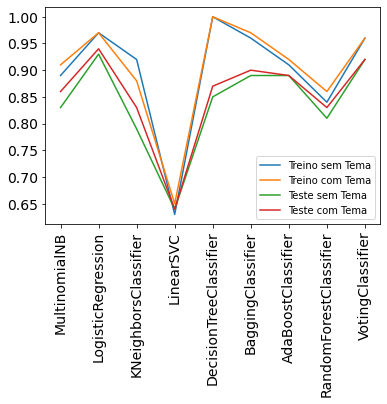

In [ ]:
modelos = ['MultinomialNB','LogisticRegression','KNeighborsClassifier','LinearSVC','DecisionTreeClassifier','BaggingClassifier','AdaBoostClassifier','RandomForestClassifier','VotingClassifier']
treino =     [0.89,0.97,0.92,0.63,1.00,0.96,0.91,0.84,0.96]
treinoTema = [0.91,0.97,0.88,0.65,1.00,0.97,0.92,0.86,0.96]
teste =      [0.83,0.93,0.79,0.64,0.85,0.89,0.89,0.81,0.92]
testeTema =  [0.86,0.94,0.83,0.64,0.87,0.90,0.89,0.83,0.92]

plt.plot(modelos, treino, label = 'Treino sem Tema')
plt.plot(modelos, treinoTema, label = 'Treino com Tema')
plt.plot(modelos, teste, label = 'Teste sem Tema')
plt.plot(modelos, testeTema, label = 'Teste com Tema')
plt.yticks(size=14)
plt.xticks(rotation=90, size=14)
plt.legend()
plt.show()

#### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train_bow, y_train_bin)
print("score on test: "  + str(clf.score(x_test_bow, y_test_bin)))
print("score on train: " + str(clf.score(x_train_bow, y_train_bin)))

score on test: 0.8673777777777778
score on train: 1.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train_tfidf, y_train_bin)
print("score on test: "  + str(clf.score(x_test_tfidf, y_test_bin)))
print("score on train: " + str(clf.score(x_train_tfidf, y_train_bin)))

score on test: 0.8641777777777778
score on train: 1.0


#### BaggingClassifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(x_train_bow, y_train_bin)
print("score on test: " + str(bg.score(x_test_bow, y_test_bin)))
print("score on train: "+ str(bg.score(x_train_bow, y_train_bin)))

score on test: 0.9034666666666666
score on train: 0.9668571428571429


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(x_train_tfidf, y_train_bin)
print("score on test: " + str(bg.score(x_test_tfidf, y_test_bin)))
print("score on train: "+ str(bg.score(x_train_tfidf, y_train_bin)))

score on test: 0.8984888888888889
score on train: 0.9661714285714286


#### AdaBoostClassifier

In [ ]:
#+- analisar parametros
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(x_train_bow, y_train_bin)
print("score on test: " + str(adb.score(x_test_bow, y_test_bin)))
print("score on train: "+ str(adb.score(x_train_bow, y_train_bin)))

score on test: 0.8917333333333334
score on train: 0.9132190476190476


In [ ]:
#+- analisar parametros
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(x_train_tfidf, y_train_bin)
print("score on test: " + str(adb.score(x_test_tfidf, y_test_bin)))
print("score on train: "+ str(adb.score(x_train_tfidf, y_train_bin)))

score on test: 0.8958222222222222
score on train: 0.9161904761904762


#### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(x_train_bow, y_train_bin)
print("score on test: " + str(rf.score(x_test_bow, y_test_bin)))
print("score on train: "+ str(rf.score(x_train_bow, y_train_bin)))

score on test: 0.8666666666666667
score on train: 0.889752380952381


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(x_train_tfidf, y_train_bin)
print("score on test: " + str(rf.score(x_test_tfidf, y_test_bin)))
print("score on train: "+ str(rf.score(x_train_tfidf, y_train_bin)))

score on test: 0.8392888888888889
score on train: 0.8671238095238095


#### VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier
# 1) naive bayes = mnb
# 2) logistic regression =lr
# 3) random forest =rf
# 4) support vector machine = svm
evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)],voting='hard')
evc.fit(x_train_bow, y_train_bin)
print("score on test: " + str(evc.score(x_test_bow, y_test_bin)))
print("score on train: "+ str(evc.score(x_train_bow, y_train_bin)))

score on test: 0.8842666666666666
score on train: 0.9133714285714286


In [ ]:
from sklearn.ensemble import VotingClassifier
# 1) naive bayes = mnb
# 2) logistic regression =lr
# 3) random forest =rf
# 4) support vector machine = svm
evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)],voting='hard')
evc.fit(x_train_tfidf, y_train_bin)
print("score on test: " + str(evc.score(x_test_tfidf, y_test_bin)))
print("score on train: "+ str(evc.score(x_train_tfidf, y_train_bin)))

score on test: 0.9278222222222222
score on train: 0.9571047619047619


### Função train_classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# criando a função
def train_classifier(x_train, y_train, C=2.5, penalty='l2'):

    # logreg = LogisticRegression(C=C, penalty=penalty, max_iter=5000)
    # one_vs_rest = OneVsRestClassifier(logreg).fit(x_train, y_train)
    # return one_vs_rest

    
    # mnb = MultinomialNB().fit(x_train, y_train)
    # return mnb

    lr=LogisticRegression(max_iter=5000)
    lr.fit(x_train, y_train)
    return lr

    # clf = DecisionTreeClassifier()
    # clf.fit(x_train, y_train)
    # return clf

    # max_samples: maximum size 0.5=50% of each sample taken from the full dataset
    # max_features: maximum of features 1=100% taken here all 10K 
    # n_estimators: number of decision trees 
    # bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
    # bg.fit(x_train, y_train)
    # return bg

    # adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
    # adb.fit(x_train, y_train)
    # return adb

    # n_estimators = number of decision trees
    # rf = RandomForestClassifier(n_estimators=30, max_depth=9)
    # rf.fit(x_train, y_train)
    # return rf

### Função print_evaluation_scores

In [ ]:
# criando a função para avaliação
def print_evaluation_scores(y_test, predicted):
    
    # calculando a acuracia
    print("Accuracy score :",accuracy_score(y_true=y_test,y_pred=predicted))
    
    # calculando f1 score
    print("F1 averaged score :",np.mean(np.array(f1_score(y_true=y_test, y_pred=predicted, average = 'micro'))))
    
    # calculando a precision score
    print("Precision score :",average_precision_score(y_true=y_test, y_score=predicted, average = 'weighted'))

### Treino dos modelos

In [ ]:
# transformando as classes em 0 e 1
lb = LabelBinarizer()

y_train_bin = lb.fit_transform(y_train['class']).ravel()
y_test_bin = lb.fit_transform(y_test['class']).ravel()

In [ ]:
# treinando um classificador com bow
classifier_bow = train_classifier(x_train_bow, y_train_bin)
# treinando um classificador com tf-idf
classifier_tfidf = train_classifier(x_train_tfidf, y_train_bin)

In [ ]:
# realizando as previsões com labels
y_test_predicted_labels_bow = classifier_bow.predict(x_test_bow)
# realizando as previsões com scores
y_test_predicted_scores_bow = classifier_bow.decision_function(x_test_bow)
# realizando as previsões com labels
y_test_predicted_labels_tfidf = classifier_tfidf.predict(x_test_tfidf)
# realizando as previsões com scores
y_test_predicted_scores_tfidf = classifier_tfidf.decision_function(x_test_tfidf)

In [ ]:
y_test_pred_inversed = lb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = lb.inverse_transform(y_test_bin)
for i in range(4):
    print('Title:\t{}\nTrue class:\t{}\nPredicted class:\t{}\n\n'.format(
        x_test['text'][i],
        y_test_inversed[i],
        y_test_pred_inversed[i]
    ))

In [ ]:
print('Bag-of-words')
print('---------------------------------------------')
print_evaluation_scores(y_test_bin, y_test_predicted_labels_bow)
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('\nTfidf')
print('---------------------------------------------')
print_evaluation_scores(y_test_bin, y_test_predicted_labels_tfidf)
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

Bag-of-words
---------------------------------------------
Accuracy score : 0.9324444444444444
F1 averaged score : 0.9324444444444444
Precision score : 0.9088660563695256
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Tfidf
---------------------------------------------
Accuracy score : 0.9413333333333334
F1 averaged score : 0.9413333333333334
Precision score : 0.9156520813951251
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_bin, classifier_tfidf.predict(x_train_tfidf))

pd.crosstab(y_train_bin, classifier_tfidf.predict(x_train_tfidf))

col_0,0,1
row_0,,
0,6233,239
1,209,6444


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_bin, classifier_tfidf.predict(x_train_tfidf))

pd.crosstab(y_test_bin, classifier_tfidf.predict(x_test_tfidf))

col_0,0,1
row_0,,
0,2540,187
1,143,2755


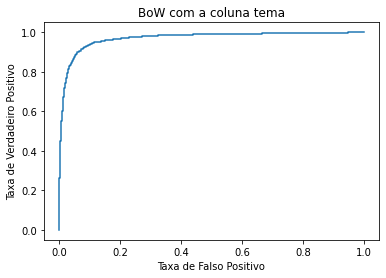

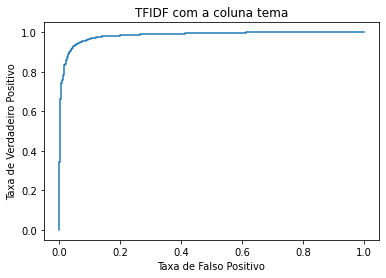

In [ ]:
classes_count = Counter(y_train["class"])

# número de classes
n_classes = len(classes_count)
# plotanco a curva para bow
fpr_bow, tpr_bow, _ = roc_curve(y_test_bin, y_test_predicted_scores_bow)
# número de classes
n_classes = len(classes_count)
# plotanco a curva para tf-idf
fpr_tf, tpr_tf, _ = roc_curve(y_test_bin, y_test_predicted_scores_tfidf)

#create ROC curve
plt.plot(fpr_bow,tpr_bow)
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.title('BoW com a coluna tema')
plt.show()

plt.plot(fpr_tf,tpr_tf)
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.title('TFIDF com a coluna tema')
plt.show()

In [ ]:
all_words = list(words_counts.keys())
est = classifier_tfidf.estimators_[0]

top_positive_words = [tfidf_reversed_vocab[index] for index in est.coef_.argsort().tolist()[0][-5:]]# top-5 words sorted by the coefficiens.
top_negative_words = [tfidf_reversed_vocab[index] for index in est.coef_.argsort().tolist()[0][:5]]# bottom-5 words  sorted by the coefficients.
print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

AttributeError: ignored

### Predição

In [ ]:
text = "patrimonio declarado filhos pecuarista jose carlos bumlai - amigo ex-presidente lula preso operacao lava jato - mauricio bumlai saltou r 3 86 milhoes 2004 r 273 80 milhoes ano 2012 numeros sao documento informacao pesquisa investigacao pr20150042 feito receita federal coloca suspeita sob evolucao patrimonial toda familia incluindo transacao imobiliaria atipica banco btg pactual - empresario andre esteves documento receita anexado pedido prisao bumlai feito procuradores forca-tarefa lava jato curitiba encaminhado procuradoria geral republica embasar inquerito levou cadeia banqueiro andre esteves dono btg pactual lider governo senado delcidio amaral pt-sp ultima quarta-feira 24 tentarem obstruir investigacoes analise feita receita base quebra sigilos fiscais familia bumlai empresas material aponta negocios suspeitos familia pecuarista banco btg pactual nomes outros parentes sao analisados outro filho fernando bumlai patrimonio declarado aumentou r 3 28 milhoes 2004 r 59 22 milhoes 2012 veja_tambem ambos irmaos comum beneficiamento valores transacao suspeita 2012 envolveu negocios familia banco esteves btg pactual aparece reestruturacao financeira usina tambem compra r 195 milhoes fazenda filhos bumlai resta suspeicao sobre valor efetivamente pago btg pactual irmaos compra imovel rural menos ja identificou-se valores faixa r 40 milhoes nao r 50 milhoes cada alem sequenciais incompreensiveis operacoes bancarias debito conta mauricio bumlai cerca r 132 milhoes fatos merecem aprofundamento investigacao registra documento receita venda imovel rural btg pactual servicos financeiros s distribuidora titulos imobiliarios beneficiou tres membros familia neste ano 2012 titularidade condominio tres irmaos imovel rural vendido 05 abril 2012 btg pactual servicos financeiros s distr tit imobiliarios verifica-se mesma apropriacao ganho capital terra nua receita atividade rural gerando expressivo valor recursos mauricio bumlai merece melhor aprofundamento confirmacao correta tributacao eventual omissao registra documento assinado auditor fiscal receita federal roberto leonel oliveira lima dia 11 alem mauricio bumlai ter beneficiado deste expressivo recurso decorrente venda imovel rural ja citado verificou-se declarou ter contraido adicionalmente suposto mutuo r 50 milhoes metade concedida cada irmaos fernando cristiane cujo vencimento 2014 nao quitado"
text_prepared = text_prepare(text)

In [ ]:
# instanciando o vetorizador
vectorizer = CountVectorizer(max_features = 5000)
# aplicando a transformação
x_train_bow = vectorizer.fit_transform(x_train['text'])
predict_bow = vectorizer.transform([text_prepared])

predict_proba = classifier_bow.predict_proba(predict_bow)[0]
predict = classifier_bow.predict(predict_bow)[0]

print("predict_proba",predict_proba)
print("predict",predict)

predict_proba [1.24627354e-29 1.00000000e+00]
predict 1


In [ ]:
# instanciando o tfidf
tfidf_vec = TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9, ngram_range = (1,2))
# aplicando o modelo com fit_transform aos dados de treino
x_train_tfidf = tfidf_vec.fit_transform(x_train['text'])
# aplicando o modelo com transform aos dados de validação
predict_tfidf = tfidf_vec.transform([text_prepared])

predict_proba = classifier_tfidf.predict_proba(predict_tfidf)[0]
predict = classifier_tfidf.predict(predict_tfidf)[0]

print("predict_proba",predict_proba)
print("predict",predict)

predict_proba [0.11598192 0.88401808]
predict 1


In [ ]:
# instanciando o tfidf
tfidf_vec = TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9, ngram_range = (1,2))
# aplicando o modelo com fit_transform aos dados de treino
x_train_tfidf = tfidf_vec.fit_transform(x_train['text'])
# aplicando o modelo com transform aos dados de validação
predict_tfidf = tfidf_vec.transform([text_prepared])

predict_proba = lr.predict_proba(predict_tfidf)[0]
predict = lr.predict(predict_tfidf)[0]

print("predict_proba",predict_proba)
print("predict",predict)


predict_proba = knn.predict_proba(predict_tfidf)[0]
predict = knn.predict(predict_tfidf)[0]

print("predict_proba",predict_proba)
print("predict",predict)

predict_proba = bg.predict_proba(predict_tfidf)[0]
predict = bg.predict(predict_tfidf)[0]

print("predict_proba",predict_proba)
print("predict",predict)

predict_proba = adb.predict_proba(predict_tfidf)[0]
predict = adb.predict(predict_tfidf)[0]

print("predict_proba",predict_proba)
print("predict",predict)

predict_proba [0.50065688 0.49934312]
predict 0
predict_proba [0.6 0.4]
predict 0
predict_proba [0.6 0.4]
predict 0
predict_proba [0.4953105 0.5046895]
predict 1


### Pickle - classifier

In [ ]:
with open('/content/classifier.pickle', 'wb') as f:
    pickle.dump(lr, f)

!zip -r "/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/classificador.zip" "/content/classifier.pickle"

updating: content/classifier.pickle (deflated 5%)


In [ ]:
with open('/content/classifier.pickle', 'rb') as f:
  classifier = pickle.load(f)
  print(type(classifier))

<class 'sklearn.linear_model._logistic.LogisticRegression'>


In [ ]:
with open('/content/tfidf_vec.pickle', 'wb') as f:
    pickle.dump(tfidf_vec, f)

with open('/content/x_train.pickle', 'wb') as f:
    pickle.dump(x_train['text'], f)

In [ ]:
text = "patrimonio declarado filhos pecuarista jose carlos bumlai - amigo ex-presidente lula preso operacao lava jato - mauricio bumlai saltou r 3 86 milhoes 2004 r 273 80 milhoes ano 2012 numeros sao documento informacao pesquisa investigacao pr20150042 feito receita federal coloca suspeita sob evolucao patrimonial toda familia incluindo transacao imobiliaria atipica banco btg pactual - empresario andre esteves documento receita anexado pedido prisao bumlai feito procuradores forca-tarefa lava jato curitiba encaminhado procuradoria geral republica embasar inquerito levou cadeia banqueiro andre esteves dono btg pactual lider governo senado delcidio amaral pt-sp ultima quarta-feira 24 tentarem obstruir investigacoes analise feita receita base quebra sigilos fiscais familia bumlai empresas material aponta negocios suspeitos familia pecuarista banco btg pactual nomes outros parentes sao analisados outro filho fernando bumlai patrimonio declarado aumentou r 3 28 milhoes 2004 r 59 22 milhoes 2012 veja_tambem ambos irmaos comum beneficiamento valores transacao suspeita 2012 envolveu negocios familia banco esteves btg pactual aparece reestruturacao financeira usina tambem compra r 195 milhoes fazenda filhos bumlai resta suspeicao sobre valor efetivamente pago btg pactual irmaos compra imovel rural menos ja identificou-se valores faixa r 40 milhoes nao r 50 milhoes cada alem sequenciais incompreensiveis operacoes bancarias debito conta mauricio bumlai cerca r 132 milhoes fatos merecem aprofundamento investigacao registra documento receita venda imovel rural btg pactual servicos financeiros s distribuidora titulos imobiliarios beneficiou tres membros familia neste ano 2012 titularidade condominio tres irmaos imovel rural vendido 05 abril 2012 btg pactual servicos financeiros s distr tit imobiliarios verifica-se mesma apropriacao ganho capital terra nua receita atividade rural gerando expressivo valor recursos mauricio bumlai merece melhor aprofundamento confirmacao correta tributacao eventual omissao registra documento assinado auditor fiscal receita federal roberto leonel oliveira lima dia 11 alem mauricio bumlai ter beneficiado deste expressivo recurso decorrente venda imovel rural ja citado verificou-se declarou ter contraido adicionalmente suposto mutuo r 50 milhoes metade concedida cada irmaos fernando cristiane cujo vencimento 2014 nao quitado"
text_prepared = text_prepare(text)

# instanciando o tfidf
tfidf_vec = TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9, ngram_range = (1,2))
# aplicando o modelo com fit_transform aos dados de treino
x_train_tfidf = tfidf_vec.fit_transform(x_train['text'])
# aplicando o modelo com transform aos dados de validação
predict_tfidf = tfidf_vec.transform([text_prepared])

predict_proba = classifier.predict_proba(predict_tfidf)[0]
predict = classifier.predict(predict_tfidf)[0]

print("predict_proba", predict_proba)
print("predict", predict)

In [ ]:
text = "patrimonio declarado filhos pecuarista jose carlos bumlai - amigo ex-presidente lula preso operacao lava jato - mauricio bumlai saltou r 3 86 milhoes 2004 r 273 80 milhoes ano 2012 numeros sao documento informacao pesquisa investigacao pr20150042 feito receita federal coloca suspeita sob evolucao patrimonial toda familia incluindo transacao imobiliaria atipica banco btg pactual - empresario andre esteves documento receita anexado pedido prisao bumlai feito procuradores forca-tarefa lava jato curitiba encaminhado procuradoria geral republica embasar inquerito levou cadeia banqueiro andre esteves dono btg pactual lider governo senado delcidio amaral pt-sp ultima quarta-feira 24 tentarem obstruir investigacoes analise feita receita base quebra sigilos fiscais familia bumlai empresas material aponta negocios suspeitos familia pecuarista banco btg pactual nomes outros parentes sao analisados outro filho fernando bumlai patrimonio declarado aumentou r 3 28 milhoes 2004 r 59 22 milhoes 2012 veja_tambem ambos irmaos comum beneficiamento valores transacao suspeita 2012 envolveu negocios familia banco esteves btg pactual aparece reestruturacao financeira usina tambem compra r 195 milhoes fazenda filhos bumlai resta suspeicao sobre valor efetivamente pago btg pactual irmaos compra imovel rural menos ja identificou-se valores faixa r 40 milhoes nao r 50 milhoes cada alem sequenciais incompreensiveis operacoes bancarias debito conta mauricio bumlai cerca r 132 milhoes fatos merecem aprofundamento investigacao registra documento receita venda imovel rural btg pactual servicos financeiros s distribuidora titulos imobiliarios beneficiou tres membros familia neste ano 2012 titularidade condominio tres irmaos imovel rural vendido 05 abril 2012 btg pactual servicos financeiros s distr tit imobiliarios verifica-se mesma apropriacao ganho capital terra nua receita atividade rural gerando expressivo valor recursos mauricio bumlai merece melhor aprofundamento confirmacao correta tributacao eventual omissao registra documento assinado auditor fiscal receita federal roberto leonel oliveira lima dia 11 alem mauricio bumlai ter beneficiado deste expressivo recurso decorrente venda imovel rural ja citado verificou-se declarou ter contraido adicionalmente suposto mutuo r 50 milhoes metade concedida cada irmaos fernando cristiane cujo vencimento 2014 nao quitado"
text_prepared = text_prepare(text)

enc = OneHotEncoder(handle_unknown='ignore')
vec =  TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9, ngram_range = (1,2))

transf = make_column_transformer((vec, 'text'),(enc, ['theme']))

transf.fit_transform(x_train)
# aplicando o modelo com transform aos dados de validação

to_predict = pd.DataFrame([[text_prepared, 'politica']], columns=['text', 'theme'])
predict_tfidf = transf.transform(to_predict)

predict_proba = classifier.predict_proba(predict_tfidf)[0]
predict = classifier.predict(predict_tfidf)[0]

print("predict_proba", predict_proba)
print("predict", predict)

predict_proba [0.55147597 0.44852403]
predict 0


### TELEBOT

In [ ]:
# this cell should be run only once, to install the telebot library
! pip install pytelegrambotapi

!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 5.2 MB/s 
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.7.0-py3-none-any.whl size=192826 sha256=b06522d65f67d108756775c6c64a2bad82cb25ed884ecaa248911fd54099e31b
  Stored in directory: /root/.cache/pip/wheels/ba/13/da/8abf941f7cf9f993cde6118a56a7c24e12ed791507acd8ea39
Successfully built pytelegrambotapi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import zipfile
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from unidecode import unidecode
import pickle
import telebot
from telebot import types
from telebot.types import ReplyKeyboardRemove

nltk.download('stopwords') # caso a lista esteja desatualizada

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/noticias_treino_teste.zip", 'r')
zip_ref.extractall("/content/treino_teste")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/My Drive/TCC 2022/DESENVOLVIMENTO/classificador.zip", 'r')
zip_ref.extractall("/")
zip_ref.close()

In [ ]:
# Buscando conjuntos de treino
pathTreino = "/content/treino_teste/content/noticias/treino_teste/noticias_treino.csv"
x_train = pd.read_csv(pathTreino, sep='|')

with open("/content/classifier.pickle", "rb") as f:
    classifier = pickle.load(f)

In [ ]:
# criando a função para ler o arquivo
def read_data(filename):
    
    # importando o arquivo
    data = pd.read_csv(filename, sep='|')
       
    # retornando o arquivo
    return data

In [ ]:
# criando os objetos com as expressões regulares
remove_espec_carac = re.compile('[/(){}\[\]\|@,;]|( - )')
remove_symb = re.compile('[^0-9a-z #+\-_]')

# criando um objeto para remoção de stopwords no idioma português
listStopwords = stopwords.words('portuguese')

# criando função para normalizar os textos
def text_prepare(text):
    
    # normalizando o texto em letras minúsculas, assim facilita a preparação
    text = text.lower()
    
    # substituindo caracteres especiais por espaços em branco
    text = remove_espec_carac.sub(' ', text)
    
    # remove os acentos
    text = unidecode(text) 

    # retornando apenas letras e números
    text = remove_symb.sub('', text)
    
    # removendo as stopwords
    text = ' '.join(word for word in text.split() if word not in listStopwords)
    
    # retornando o texto modificado
    return text

In [ ]:
mensagem_bem_vindo = "Bem vindo(a)!\n\
Esse é um projeto de Aprendizado de Máquina e Processamento de Linguagem Natural.\n\
Baseado em um conjunto amplo de notícias, um algoritmo foi treinado para classificar notícias em verdadeiras ou falsas.\n\
Cole aqui a sua notícia para saber se ela pode ser falsa."

mensagem_verdadeira = "Essa notícia parece ser verdadeira!\n\
Lembre-se sempre de verificar a fonte da notícia, sites desconhecidos podem ser um alerta.\n\
Faça uma busca rápida para encontrar outras fontes.\n\
Se foi uma mensagem encaminhada muitas vezes evite repassar antes de conferir a autenticidade.\n\
Cuidado com notícias que causam espanto ou indignação, essa pode ser uma estratégia utilizada em fake news quando são misturadas com notícias verdadeiras.\n\
Algumas agências de checagem que você pode visitar são: Aos Fatos, Agência Lupa, Fato ou Fake e o Projeto Comprova."

mensagem_falsa = "Essa notícia parece ser falsa!\n\
Lembre-se sempre de verificar a fonte da notícia, sites desconhecidos podem ser um alerta.\n\
Faça uma busca rápida para encontrar outras fontes.\n\
Se foi uma mensagem encaminhada muitas vezes evite repassar antes de conferir a autenticidade.\n\
Cuidado com notícias que causam espanto ou indignação, essa pode ser uma estratégia utilizada em fake news quando são misturadas com notícias verdadeiras.\n\
Algumas agências de checagem que você pode visitar são: Aos Fatos, Agência Lupa, Fato ou Fake e o Projeto Comprova."

mensagem_tema = "Ok. Você pode ajudar na classificação definindo um tema para sua notícia, clique nessa mensagem e selecione o tema!"

#### SEM TEMA

In [ ]:
API_TOKEN = "5742068832:AAEbFs15nqoVHQhSMNRKZbLKGYRwkuSUaSk"

bot = telebot.TeleBot(API_TOKEN)


@bot.message_handler()
def send_welcome(message):
    try:
      msg = bot.send_message(
          message.chat.id,
          mensagem_bem_vindo,
      )

      bot.register_next_step_handler(msg, process_noticia)
    except Exception as e:
      bot.send_message(message.chat.id, 'Desculpe, algo deu errado.')

def process_noticia(message):
    try:
      msg = bot.send_message(
          message.chat.id,
          "Processando a notícia...",
      )
      resultado = predict(message.text)

      if resultado == 1:
          bot.reply_to(
              message,
              mensagem_verdadeira,
          )
      else:
          bot.reply_to(
              message,
              mensagem_falsa,
          )
    except Exception as e:
      bot.send_message(message.chat.id, 'Desculpe, algo deu errado.')

def predict(text):
    text_prepared = text_prepare(text)

    tfidf_vec = TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9, ngram_range = (1,2))

    tfidf_vec.fit_transform(x_train['text'])

    predict_tfidf = tfidf_vec.transform([text_prepared])

    predict_proba = classifier.predict_proba(predict_tfidf)[0]
    predict = classifier.predict(predict_tfidf)[0]

    print("predict_proba", predict_proba)
    print("predict", predict)
    return predict

bot.infinity_polling()


2022-10-10 19:45:24,475 (__init__.py:884 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2022-10-10 19:45:24,480 (__init__.py:886 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling


#### COM TEMA

In [ ]:
API_TOKEN = "5742068832:AAEbFs15nqoVHQhSMNRKZbLKGYRwkuSUaSk"

bot = telebot.TeleBot(API_TOKEN)

noticia_dict = {}

markup = types.ReplyKeyboardMarkup(one_time_keyboard=True, resize_keyboard=True)
markup.add('Política','Saúde','Entretenimento','Mundo','Brasil','Ciência/Tecnologia','Religião',"Economia")

class Noticia:
    def __init__(self, text, msg):
        self.msg = msg
        self.text = text
        self.theme = None

@bot.message_handler()
def send_welcome(message):
    try:
      msg = bot.send_message(
          message.chat.id,
          mensagem_bem_vindo,
          reply_markup=ReplyKeyboardRemove()
      )

      bot.register_next_step_handler(msg, ask_theme)
    except Exception as e:
      bot.send_message(message.chat.id, 'Desculpe, algo deu errado.')

def ask_theme(message):
    try:
      chat_id = message.chat.id
      text = message.text
      noticia = Noticia(text, message)
      noticia_dict[chat_id] = noticia

      msg = bot.reply_to(message, mensagem_tema, reply_markup=markup)

      bot.register_next_step_handler(msg, process_noticia)
    except Exception as e:
      bot.send_message(message.chat.id, 'Desculpe, algo deu errado.')


def process_noticia(message):
    try:
      chat_id = message.chat.id
      noticia = noticia_dict[chat_id]
      noticia.theme = message.text

      if message.text == 'Política':
         noticia.theme = 'politica'
      elif message.text == 'Saúde':
          noticia.theme = 'saude'
      elif message.text == 'Entretenimento':
          noticia.theme = 'entretenimento'
      elif message.text == 'Mundo':
          noticia.theme = 'mundo'
      elif message.text == 'Brasil':
          noticia.theme = 'brasil'
      elif message.text == 'Ciência/Tecnologia':
          noticia.theme = 'ciencia_tecnologia'
      elif message.text == 'Religião':
          noticia.theme = 'religiao'
      elif message.text == 'Economia':
          noticia.theme = 'economia'
      else: 
          bot.reply_to(
                message,
                "Selecione um dos temas fornecidos.",
            )
          msg = bot.reply_to(message, mensagem_tema, reply_markup=markup)
          bot.register_next_step_handler(msg, process_noticia)
          return

      msg = bot.send_message(
          message.chat.id,
          "Processando a notícia...",
          reply_markup=ReplyKeyboardRemove()
      )


      resultado = predict(noticia.text, noticia.theme)

      del noticia_dict[chat_id]

      if resultado == 1:
          bot.reply_to(
              noticia.msg,
              mensagem_verdadeira,
          )
      else:
          bot.reply_to(
              noticia.msg,
              mensagem_falsa,
          )
    except Exception as e:
      print(e)
      chat_id = message.chat.id
      if noticia_dict[chat_id]:
        del noticia_dict[chat_id]
      bot.send_message(message.chat.id, 'Desculpe, algo deu errado.')

def predict(text , theme):
    text_prepared = text_prepare(text)

    enc = OneHotEncoder(handle_unknown='ignore')
    vec =  TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9, ngram_range = (1,2))

    transf = make_column_transformer((vec, 'text'),(enc, ['theme']))

    transf.fit_transform(x_train)

    to_predict = pd.DataFrame([[text_prepared, theme]], columns=['text', 'theme'])
    predict_transform = transf.transform(to_predict)

    predict_proba = classifier.predict_proba(predict_transform)[0]
    predict = classifier.predict(predict_transform)[0]

    print("predict_proba", predict_proba)
    print("predict", predict)
    return predict

bot.infinity_polling()


predict_proba [0.92803193 0.07196807]
predict 0
predict_proba [0.88168881 0.11831119]
predict 0
predict_proba [0.77022286 0.22977714]
predict 0
predict_proba [0.71504801 0.28495199]
predict 0
predict_proba [0.20106215 0.79893785]
predict 1
predict_proba [0.7550774 0.2449226]
predict 0
predict_proba [0.7550774 0.2449226]
predict 0
predict_proba [0.67679615 0.32320385]
predict 0
predict_proba [0.33645758 0.66354242]
predict 1
predict_proba [0.64468918 0.35531082]
predict 0
predict_proba [0.42278273 0.57721727]
predict 1


2022-10-10 20:20:31,452 (__init__.py:884 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2022-10-10 20:20:31,460 (__init__.py:886 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling


#### Para print

In [ ]:
x_train = pd.read_csv(pathTreino, sep='|')
with open(path_classifier, "rb") as f:
    classifier = pickle.load(f)

API_TOKEN = ""
bot = telebot.TeleBot(API_TOKEN)

markup = types.ReplyKeyboardMarkup(one_time_keyboard=True, resize_keyboard=True)
markup.add('Política','Saúde','Entretenimento','Mundo','Brasil',
           'Ciência/Tecnologia','Religião',"Economia")

noticia_dict = {}
class Noticia:
    def __init__(self, text, msg):
        self.msg = msg
        self.text = text
        self.theme = None

@bot.message_handler()
def send_welcome(message):
    try:
      msg = bot.send_message(
          message.chat.id,
          mensagem_bem_vindo,
          reply_markup=ReplyKeyboardRemove()
      )
      bot.register_next_step_handler(msg, ask_theme)
    except Exception as e:
      bot.send_message(message.chat.id, 'Desculpe, algo deu errado.')
def ask_theme(message):
    try:
      chat_id = message.chat.id
      text = message.text
      noticia = Noticia(text, message)
      noticia_dict[chat_id] = noticia
      msg = bot.reply_to(message, mensagem_tema, reply_markup=markup)
      bot.register_next_step_handler(msg, process_noticia)
    except Exception as e:
      bot.send_message(message.chat.id, 'Desculpe, algo deu errado.')


def process_noticia(message):
    try:
      chat_id = message.chat.id
      noticia = noticia_dict[chat_id]
      if message.text == 'Política':
         noticia.theme = 'politica'
      #aqui vai o restante das validações para cada tema
      else: 
          bot.reply_to(
                message,
                "Selecione um dos temas fornecidos.",
            )
          msg = bot.reply_to(message, mensagem_tema, reply_markup=markup)
          bot.register_next_step_handler(msg, process_noticia)
          return
      msg = bot.send_message(message.chat.id,"Processando a notícia...",
          reply_markup=ReplyKeyboardRemove()
      )
      resultado = predict(noticia.text, noticia.theme)
      del noticia_dict[chat_id]
      if resultado == 1:
          bot.reply_to(noticia.msg, mensagem_verdadeira)
      else:
          bot.reply_to(noticia.msg, mensagem_falsa)
    except Exception as e:
      chat_id = message.chat.id
      if noticia_dict[chat_id]:
        del noticia_dict[chat_id]
      bot.send_message(message.chat.id, 'Desculpe, algo deu errado.')

def predict(text , theme):
    text_prepared = text_prepare(text)
    enc = OneHotEncoder(handle_unknown='ignore')
    vec =  TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9,
                           ngram_range = (1,2))
    transf = make_column_transformer((vec, 'text'),(enc, ['theme']))
    transf.fit_transform(x_train)
    to_predict= pd.DataFrame([[text_prepared, theme]],columns=['text', 'theme'])
    predict_transform = transf.transform(to_predict)
    predict_proba = classifier.predict_proba(predict_transform)[0]
    predict = classifier.predict(predict_transform)[0]
    print("predict_proba", predict_proba)
    print("predict", predict)
    return predict

bot.infinity_polling()

NameError: ignored